In [52]:
import pandas as pd
import numpy as np
import datatable as dt
from tqdm import tqdm_notebook
import graphviz
import json
from collections import defaultdict
from gplearn.functions import make_function
from sklearn.feature_extraction import DictVectorizer
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor, SymbolicClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

ACTIONS_WITH_ITEM_REFERENCE = {
    "search for item",
    "interaction item info",
    "interaction item image",
    "interaction item deals",
    "interaction item rating",
    "clickout item",
}

In [53]:
df = pd.read_csv("../../../data/events_sorted_trans_mini.csv", nrows=100000) 

In [55]:
# price_cols = [col for col in df_all.columns if col.startswith("price_")]
# item_id_cols = [col for col in df_all.columns if col.startswith("item_id_impressions_clickout_item")]
vect = DictVectorizer(sparse=False)
X_at = vect.fit_transform(df["actions_tracker"].map(json.loads))
X = pd.DataFrame(np.hstack([df[["clickout_id", "rank"]].values, X_at]), columns=["clickout_id", "rank"] + vect.get_feature_names())
y = df["was_clicked"].values
print(list(X.shape))

[100000, 356]


In [60]:
X["interaction_00_timestamp"].value_counts()

0.000000    38277
0.693147     2594
1.609438     2497
1.098612     2234
1.945910     2186
1.791759     2124
1.386294     2119
2.079442     1851
2.197225     1704
2.302585     1625
2.397895     1267
2.484907      904
2.639057      890
2.708050      859
2.772589      770
2.564949      761
2.833213      711
3.258097      585
2.995732      580
3.178054      539
3.218876      536
2.944439      511
3.295837      482
3.332205      479
3.044522      470
2.890372      447
3.091042      447
4.262680      427
3.583519      407
3.135494      401
            ...  
6.800170       21
6.507278       20
5.852202       20
7.143618       20
6.781058       20
5.752573       19
6.933423       17
5.723585       17
5.739793       17
5.407172       16
5.609472       16
6.570883       16
6.908755       16
5.579730       16
6.725034       15
6.291569       15
5.717028       15
4.905275       14
6.242223       13
6.248043       12
5.908083       11
6.059123       10
6.129050       10
5.347108       10
6.347389  

In [61]:
def _logical(x1, x2, x3, x4):
    return np.where(x1 > x2, x3, x4)

logical = make_function(function=_logical,
                        name='logical',
                        arity=4)

def _eq(x1, x2):
    return np.where(x1 == x2, 1, 0)

eq = make_function(function=_eq,
                        name='eq',
                        arity=2)


est = SymbolicClassifier(parsimony_coefficient=.001,
                  random_state=1,
                  population_size=10000,
                  function_set=['add', 'sub', 'mul', 'div', 'min', 'max', logical, eq], #, 'sqrt', 'log', 'abs', 'neg', 'inv'],
                  feature_names=X.columns,
                  n_jobs=1,
                  verbose=True)

X_tr, X_va, y_tr, y_va, df_tr, df_va = train_test_split(X, y, df)
est.fit(X_tr, y_tr)

va_pred = est.predict_proba(X_va)[:,1]
tr_pred = est.predict_proba(X_tr)[:,1]

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    42.83          1.39425      225         0.232498              N/A     66.34m
   1    28.96         0.770386      187         0.211561              N/A   1100.63m
   2    45.80         0.562672       31         0.182882              N/A     80.92m
   3    43.70         0.423723       91         0.173464              N/A     80.58m
   4    27.68         0.405639       91         0.172371              N/A     44.81m
   5    24.42         0.371364       29         0.170688              N/A     35.28m
   6    19.96         0.375646       17         0.169588              N/A     27.87m
   7    16.70         0.417469       19         0.162063              N/A     22.27m
   8    15.34         0.444896       23         0.161995              N/A  

In [62]:
set(va_pred)

{0.024521012921978173,
 0.06396012714567074,
 0.15664601549956256,
 0.33550328231093324}

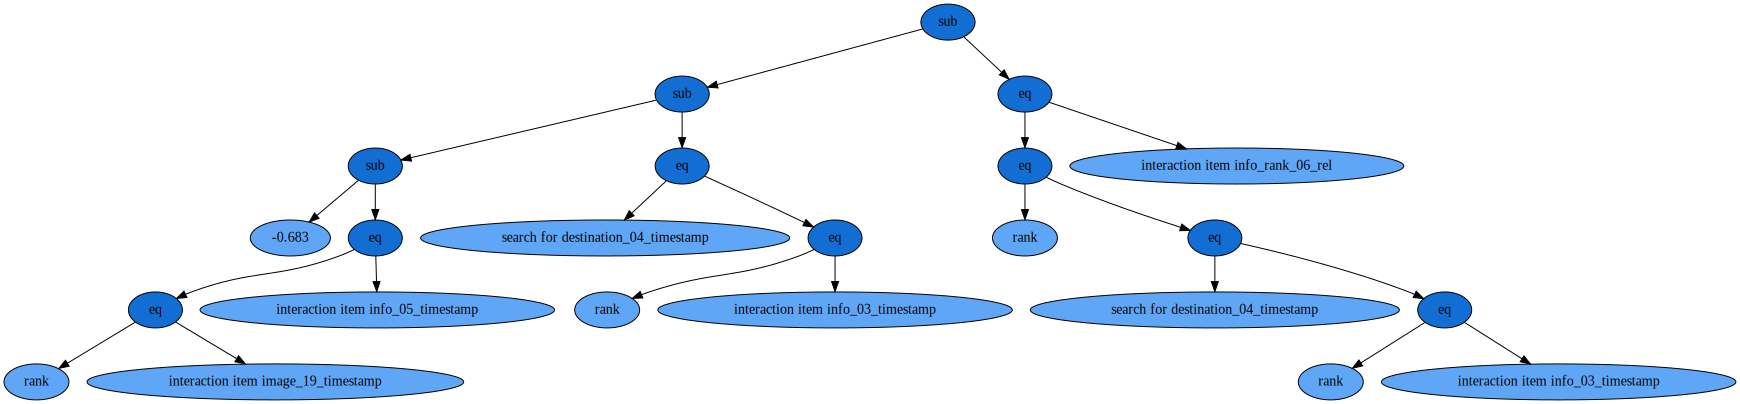

In [64]:
dot_data = est._program.export_graphviz()
# dot_data = [p for p in est.steps[0][1].transformer_list[0][1]._programs[0] if p][6].export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [169]:
fimp = list(zip(X.columns, est.feature_importances_))
df_imp = pd.DataFrame.from_records(fimp, columns=["col", "imp"])
df_imp.sort_values("imp", ascending=False)

AttributeError: 'SymbolicRegressor' object has no attribute 'feature_importances_'

In [19]:
from recsys.metric import mrr_fast_v2, mrr_fast

In [23]:
for col in X.columns:
    print(col, X[col].sum(), mrr_fast_v2(df["was_clicked"], X[col]-0.0001*X["rank"], df["clickout_id"]))

rank 1141730.0 0.09958046526521183
change of sort order_00_timestamp 41739.28547997449 0.4818846187852038
change of sort order_01_timestamp 43479.60836355066 0.4818846187852038
change of sort order_02_timestamp 21311.220790807387 0.4818846187852038
change of sort order_03_timestamp 18633.90122932055 0.4818846187852038
change of sort order_04_timestamp 7920.831248475588 0.4818846187852038
change of sort order_05_timestamp 7086.818969086567 0.4818846187852038
change of sort order_06_timestamp 2425.451372851746 0.4818846187852038
change of sort order_07_timestamp 2119.235475552943 0.4818846187852038
change of sort order_08_timestamp 1283.8996555728477 0.4818846187852038
change of sort order_09_timestamp 1060.1184993326913 0.4818846187852038
change of sort order_10_timestamp 274.9911708760793 0.4818846187852038
clickout item_00_timestamp 72236.04611755912 0.4818846187852038
clickout item_01_timestamp 91456.25604848303 0.4818846187852038
clickout item_02_timestamp 54779.735861093395 0.48188

co_price_09_09 1573.4912299843163 0.4818846187852038
co_price_09_10 742.3268660452406 0.4818846187852038
co_price_10_00 175065.7906353081 0.4818846187852038
co_price_10_01 83959.4121129514 0.4818846187852038
co_price_10_02 43905.528373862995 0.4818846187852038
co_price_10_03 24772.705180187342 0.4818846187852038
co_price_10_04 15659.591140735529 0.4818846187852038
co_price_10_05 9721.385789218008 0.4818846187852038
co_price_10_06 5845.409678263105 0.4818846187852038
co_price_10_07 3408.9104695620013 0.4818846187852038
co_price_10_08 2201.760367857751 0.4818846187852038
co_price_10_09 1365.0082983244188 0.4818846187852038
co_price_10_10 635.2840252761146 0.4818846187852038
co_price_11_00 174455.12808833562 0.4818846187852038
co_price_11_01 84448.18887050908 0.4818846187852038
co_price_11_02 44894.79029940465 0.4818846187852038
co_price_11_03 25628.785375030817 0.4818846187852038
co_price_11_04 16329.079401672157 0.4818846187852038
co_price_11_05 10262.47114854981 0.4818846187852038
co_p

co_price_24_02 38673.65743007837 0.4818846187852038
co_price_24_03 21757.39487783662 0.4818846187852038
co_price_24_04 13647.573761878517 0.4818846187852038
co_price_24_05 8263.82833461868 0.4818846187852038
co_price_24_06 4631.342099996262 0.4818846187852038
co_price_24_07 2482.5708551139705 0.4818846187852038
co_price_24_08 1424.585887123064 0.4818846187852038
co_price_24_09 796.5001505935497 0.4818846187852038
co_price_24_10 269.2247531394545 0.4818846187852038
filter selection_00_timestamp 60776.71846872668 0.4818846187852038
filter selection_01_timestamp 43883.601984788096 0.4818846187852038
filter selection_02_timestamp 29106.46393535432 0.4818846187852038
filter selection_03_timestamp 19123.45445584602 0.4818846187852038
filter selection_04_timestamp 13070.160951642347 0.4818846187852038
filter selection_05_timestamp 9735.721538287371 0.4818846187852038
filter selection_06_timestamp 6495.867769995144 0.4818846187852038
filter selection_07_timestamp 5650.004211231726 0.4818846187

search for destination_00_timestamp 112806.29951170213 0.4818846187852038
search for destination_01_timestamp 31386.92453519712 0.4818846187852038
search for destination_02_timestamp 8117.791837399076 0.4818846187852038
search for destination_03_timestamp 3363.6520298045375 0.4818846187852038
search for destination_04_timestamp 779.9203350098575 0.4818846187852038
search for destination_05_timestamp 299.49262882243715 0.4818846187852038
search for destination_06_timestamp 133.31796983163423 0.4818846187852038
search for destination_07_timestamp 141.83308167928732 0.4818846187852038
search for item_00_timestamp 21803.512180757996 0.4818846187852038
search for item_01_timestamp 9620.22741287973 0.4818846187852038
search for item_02_timestamp 3474.59137199403 0.4818846187852038
search for item_03_timestamp 262.40043922146356 0.4818846187852038
search for item_04_timestamp 140.4192774416643 0.4818846187852038
search for item_05_timestamp 143.08962754880952 0.4818846187852038
search for ite